In [2]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from fairlearn.metrics import MetricFrame
from fairlearn.metrics import demographic_parity_difference, equalized_odds_difference, true_positive_rate, false_positive_rate
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
import seaborn as sns

In [3]:
home_dir = os.path.expanduser("~")
G1 = nx.read_edgelist(f"{home_dir}/Downloads/assignment2_files_2024/edges_train.edgelist", data=False, nodetype = int, delimiter=',')
node_df = pd.read_csv(f"{home_dir}/Downloads/assignment2_files_2024/attributes.csv")
for index, row in node_df.iterrows():
    node = row['ID']
    category = row['attribute']
    if node in G1.nodes:
        G1.nodes[node]['attribute'] = category

        
category_color_map = {
    'x': 'red',
    'd': 'blue',
    'y': 'green',
    'f': 'purple',
    'm': 'orange',
    'l': 'yellow'
}

node_colors = [category_color_map[G1.nodes[node]['attribute']] for node in G1.nodes]


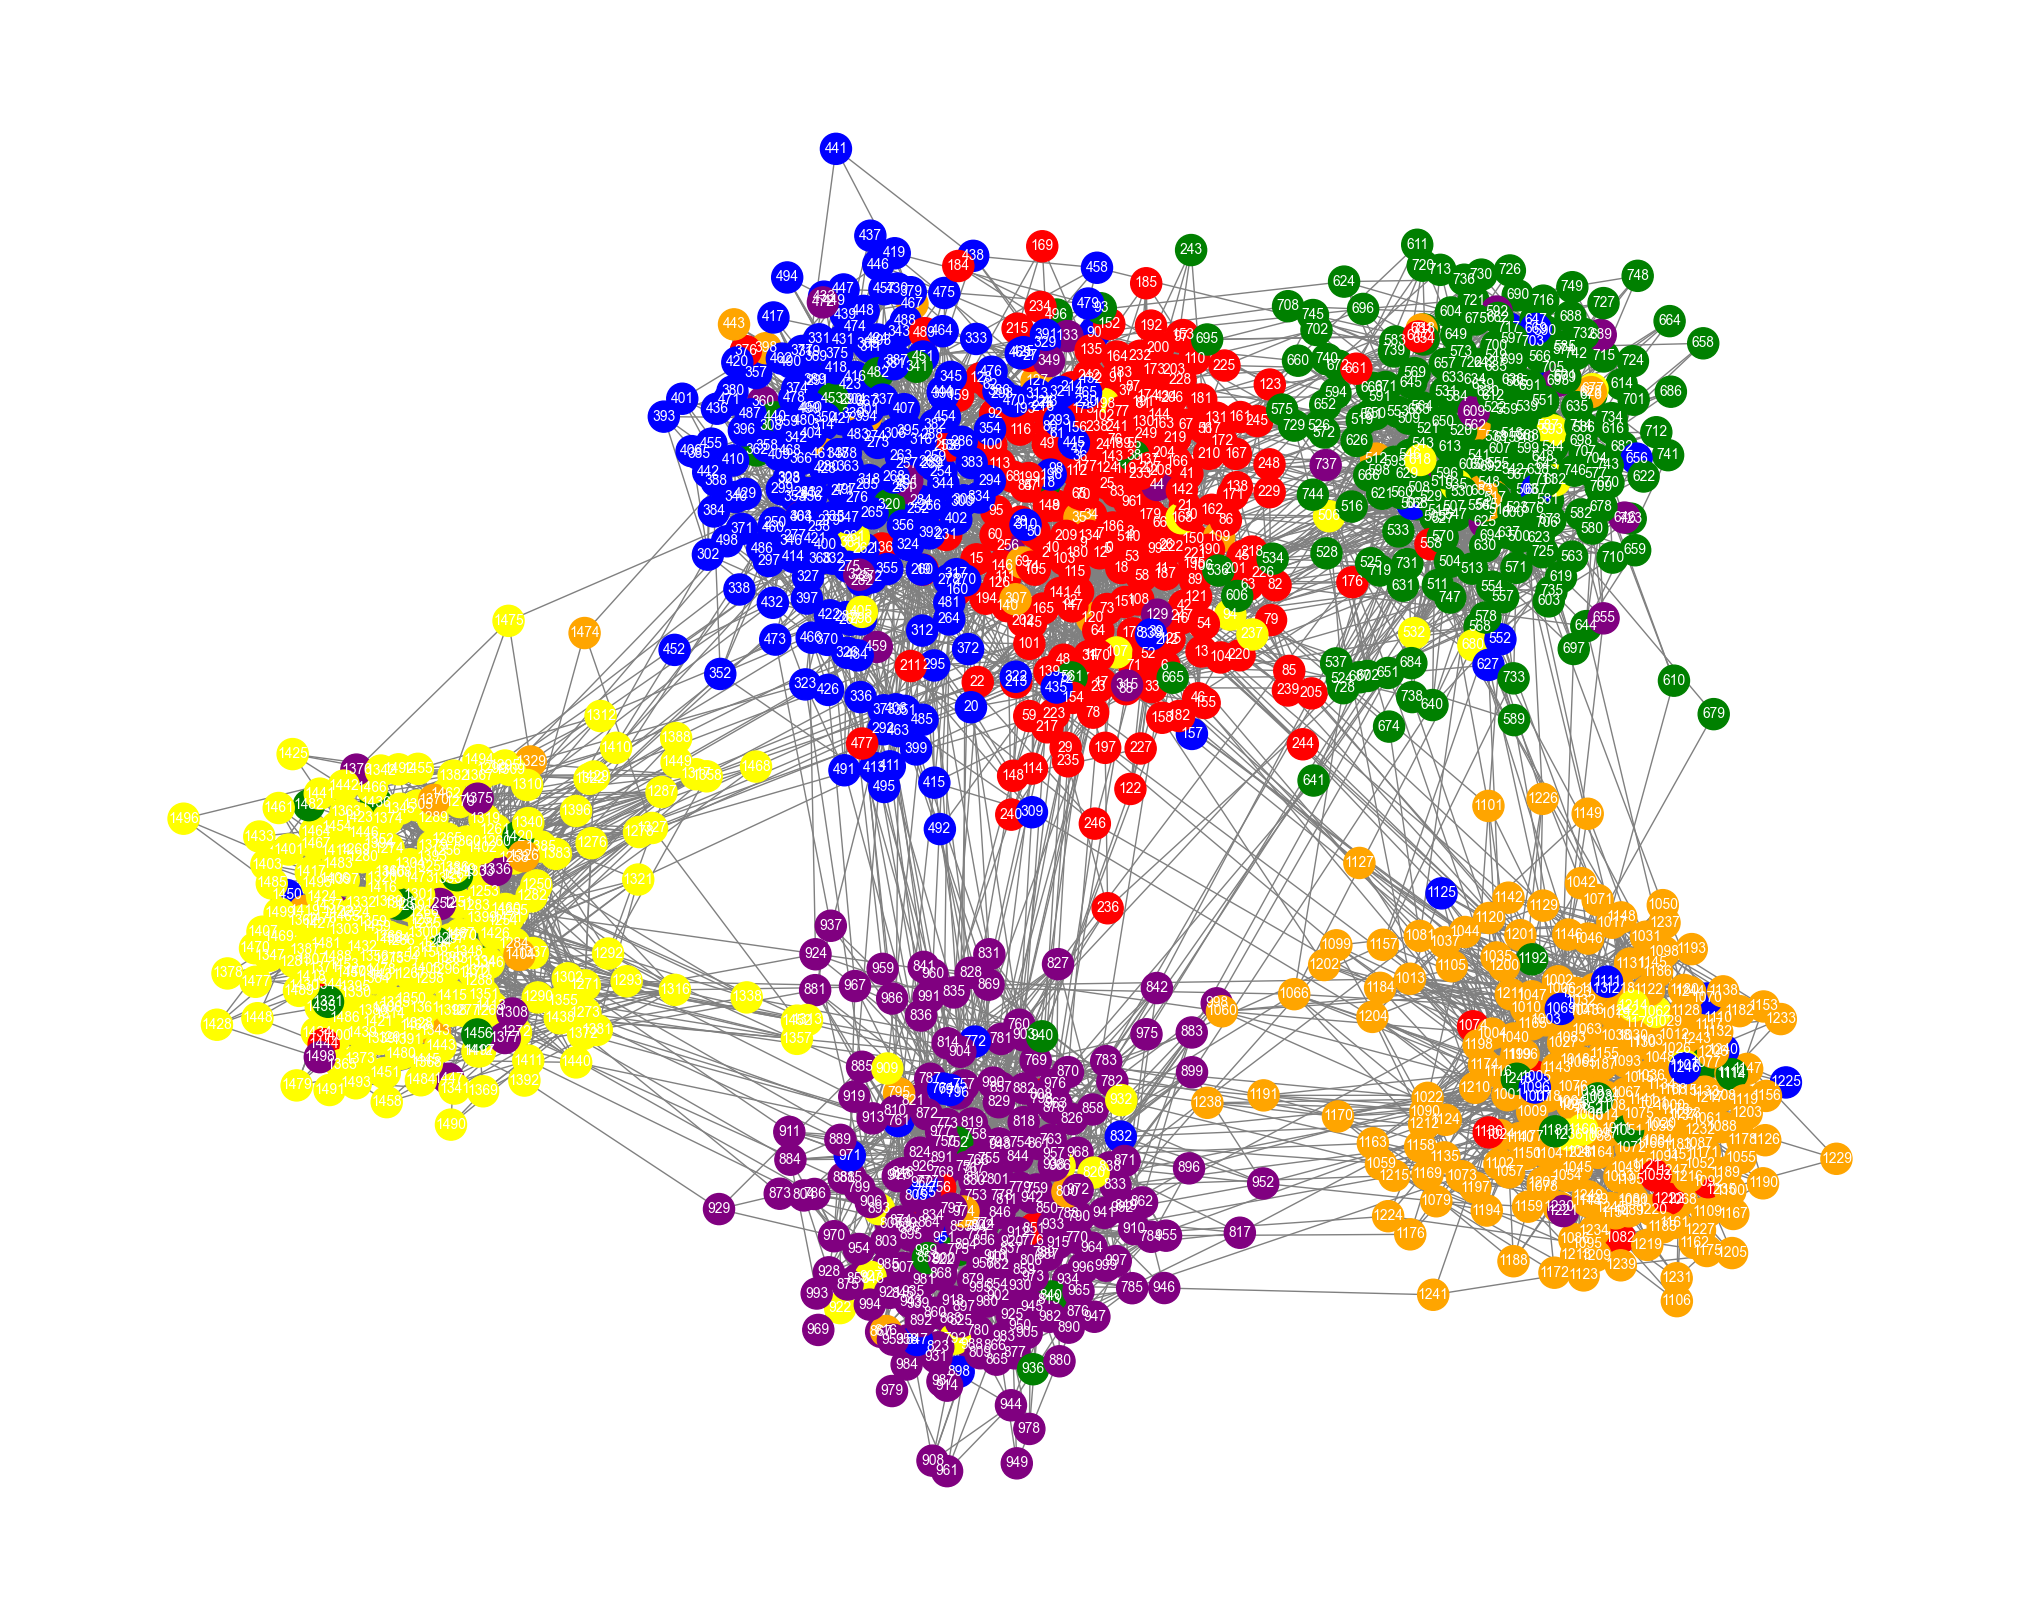

In [4]:
plt.figure(figsize=(20, 16))
pos = nx.spring_layout(G1) 
nx.draw(G1, pos, with_labels=True, node_color=node_colors, node_size=500, font_size=10, font_color='white', edge_color='gray')

plt.show()

In [5]:
attribute_map = {
        'x': 1,
        'd': 2,
        'y': 3,
        'f': 4,
        'm': 5,
        'l': 6
    }

def get_feature(G, i, j):
    pa = list(nx.preferential_attachment(G, [(i, j)]))[0][2]
    cn = len(list(nx.common_neighbors(G, i, j)))
    jc = list(nx.jaccard_coefficient(G, [(i, j)]))[0][2]
    aa = list(nx.adamic_adar_index(G, [(i, j)]))[0][2]
    ra = list(nx.resource_allocation_index(G, [(i, j)]))[0][2]
    attribute_match = 1 if G.nodes[i]['attribute'] == G.nodes[j]['attribute'] else 0
    sensitive_attr = attribute_map[G.nodes[i]['attribute']]

    return [pa, cn, jc, aa, ra, attribute_match, sensitive_attr]

In [6]:
X = []
Y = []

for (i, j) in G1.edges:
    X.append(get_feature(G1, i, j))
    Y.append(1)

num_positive = len(G1.edges)

negative_samples = set()
N = G1.number_of_nodes()

while len(negative_samples) < num_positive:
    i = np.random.randint(N)
    j = np.random.randint(N)

    if not G1.has_edge(i, j) and i != j:
        X.append(get_feature(G1, i, j))
        Y.append(0)
        negative_samples.add((i, j))

same_attribute_count = 0
for i, j in G1.edges:
    if G1.nodes[i]['attribute'] == G1.nodes[j]['attribute']:
        same_attribute_count += 1

print("Chance of nodes in an edge having the same attribute: %0.2f." % (same_attribute_count / len(G1.edges)))


Chance of nodes in an edge having the same attribute: 0.71.


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

X_train = np.array(X_train)
X_test = np.array(X_test)

# clf = RandomForestClassifier(random_state=42)
# clf = KNeighborsClassifier(n_neighbors=5)
clf = LogisticRegression(random_state=42, max_iter=1000)
clf.fit(X_train, y_train)

y_predd = clf.predict(X_test)

cv_scores = cross_val_score(clf, X, Y, cv=5, scoring='accuracy', n_jobs=-1)

# Evaluate the model
print("Cross-validation accuracies:", cv_scores)
print("Mean cross-validation accuracy: %0.4f" % cv_scores.mean())
print("Standard deviation of cross-validation accuracy: %0.4f" % cv_scores.std())

Cross-validation accuracies: [0.82179342 0.84292203 0.80393641 0.81945496 0.73959122]
Mean cross-validation accuracy: 0.8055
Standard deviation of cross-validation accuracy: 0.0352


In [8]:

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  
    'penalty': ['l1', 'l2'],       
    'solver': ['lbfgs', 'saga'],            
    'max_iter': [100, 500, 1000]
}

lr = LogisticRegression(random_state=42)


grid_search = GridSearchCV(estimator=lr, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

cv_scores = cross_val_score(best_model, X, Y, cv=5, scoring='accuracy', n_jobs=-1)

print("Best Hyperparameters:", grid_search.best_params_)
print("Cross-validation accuracies:", cv_scores)
print("Mean cross-validation accuracy: %0.4f" % cv_scores.mean())
print("Standard deviation of cross-validation accuracy: %0.4f" % cv_scores.std())

/Users/jonathan/fds_assignments/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jonathan/fds_assignments/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jonathan/fds_assignments/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jonathan/fds_assignments/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/jonathan/fds_assignments/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.w

Best Hyperparameters: {'C': 10, 'max_iter': 500, 'penalty': 'l2', 'solver': 'lbfgs'}
Cross-validation accuracies: [0.82292849 0.84330053 0.80431491 0.82059046 0.74526874]
Mean cross-validation accuracy: 0.8073
Standard deviation of cross-validation accuracy: 0.0334


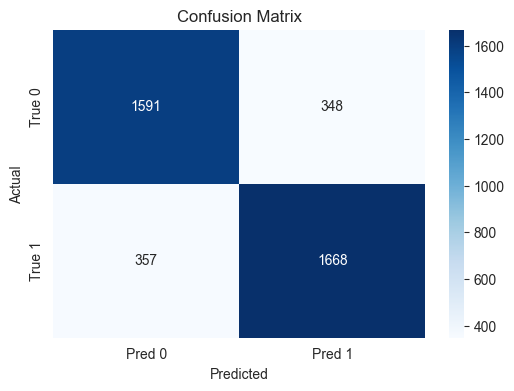

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.82      0.82      1939
           1       0.83      0.82      0.83      2025

    accuracy                           0.82      3964
   macro avg       0.82      0.82      0.82      3964
weighted avg       0.82      0.82      0.82      3964

Accuracy: 0.8221
Precision: 0.8274
Recall: 0.8237
F1 Score: 0.8255


In [9]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred 0', 'Pred 1'], yticklabels=['True 0', 'True 1'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


In [10]:
sensitive_attr = X_test[:, -1] 

reverse_attribute_map = {
    1: 'x',
    2: 'd',
    3: 'y',
    4: 'f',
    5: 'm',
    6: 'l'
}

sensitive_attr = [reverse_attribute_map[attr] for attr in sensitive_attr]

def false_negative_rate(y_true, y_pred):
    fn = ((y_true == 1) & (y_pred == 0)).sum()
    actual_positives = (y_true == 1).sum()
    return fn / actual_positives if actual_positives > 0 else 0

metric_frame = MetricFrame(
    metrics={'accuracy': accuracy_score, 
             'precision': precision_score, 
             'recall': recall_score, 
             'f1_score': f1_score, 
             'true_positive_rate': true_positive_rate,
             'false_positive_rate': false_positive_rate,
             'false_negative_rate': false_negative_rate},
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=sensitive_attr
)

print("Fairness Metrics per Sensitive Group:")
print(metric_frame.by_group)

demographic_parity = demographic_parity_difference(y_test, y_pred, sensitive_features=sensitive_attr)
equalized_odds = equalized_odds_difference(y_test, y_pred, sensitive_features=sensitive_attr)

print(f"Demographic Parity Difference: {demographic_parity:.4f}")
print(f"Equalized Odds Difference: {equalized_odds:.4f}")


Fairness Metrics per Sensitive Group:
                     accuracy  precision    recall  f1_score  \
sensitive_feature_0                                            
d                    0.827697   0.807927  0.857605  0.832025   
f                    0.850291   0.840580  0.857988  0.849195   
l                    0.863299   0.879888  0.865385  0.872576   
m                    0.804734   0.806358  0.811047  0.808696   
x                    0.778098   0.816860  0.755376  0.784916   
y                    0.808824   0.806780  0.798658  0.802698   

                     true_positive_rate  false_positive_rate  \
sensitive_feature_0                                            
d                              0.857605             0.201923   
f                              0.857988             0.157143   
l                              0.865385             0.139159   
m                              0.811047             0.201807   
x                              0.755376             0.195652   
y

In [11]:
solution_df = pd.read_csv(f"{home_dir}/Downloads/assignment2_files_2024/solutionInput.csv")

links_to_predict = list(zip(solution_df['int1'], solution_df['int2']))

X_solution = [get_feature(G1, i, j) for i, j in links_to_predict]
X_solution = np.array(X_solution)

y_solution_pred = clf.predict(X_solution)

output_df = pd.DataFrame({
    'ID': range(len(solution_df)),
    'prediction': y_solution_pred
})

output_path = f"{home_dir}/Downloads/assignment2_files_2024/solutionOutput.csv"
output_df.to_csv(output_path, index=False)

print(f"Predictions saved to {output_path}")


Predictions saved to /Users/jonathan/Downloads/assignment2_files_2024/solutionOutput.csv
